In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(".."))

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import open_cp

# Knox statistic

The "Knox statistic" is a way of detecting if events are clustered in space and time.  It has been used in the crime predicition literature to find natural "bandwidths" for use with, e.g. the prospective space/time scan.

References:

1. Johnson, Bowers, "The Burglary as Clue to the Future: The Beginnings of Prospective Hot-Spotting", European Journal of Criminology Volume: 1 issue: 2, page(s): 237-255.  DOI: https://doi.org/10.1177/1477370804041252
2. Johnson, S.D., Bernasco, W., Bowers, K.J. et al. "Space–Time Patterns of Risk: A Cross National Assessment of Residential Burglary Victimization", J Quant Criminol (2007) 23: 201. doi:10.1007/s10940-007-9025-3
3. Johnson, S.D., Bernasco, W., Bowers, K.J. et al. "Space–Time Patterns of Risk: A Cross National Assessment of Residential Burglary Victimization", J Quant Criminol (2007) 23: 201. doi:10.1007/s10940-007-9025-3
4. Knox, "Epidemiology of Childhood Leukaemia in Northumberland and Durham", Br J Prev Soc Med. 1964 Jan; 18(1): 17–24.  [Available here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1058931/)
5. Besag, Diggle, "Simple Monte Carlo Tests for Spatial Pattern",  Journal of the Royal Statistical Society. Series C (Applied Statistics) Vol. 26, No. 3 (1977), pp. 327-333 [Available from JSTOR](https://www.jstor.org/stable/2346974)

## The statistic

Papers 1--3 give details of the application to crime prediction / analysis.  Paper 4 is the original work of Knox, and paper 5 gives details of the monte carlo method which we use.

We start with a set of events which occur in space and time.  For each pair of events, we look at the spatial distance between them, and the time distance.  We count the number of events which are "close" (for various cut-off values) in both space and time.  The count of such events is significant if it is extreme compared to the expected count.  In the original work, a Poisson approximation was used, but in our application, the general background rate of e.g. crime varies with space and possibly time, and so model fitting becomes a problem.

Instead we adopt a monte carlo approach.  Repeatedly, we shuffle the timestamps of the events, while keeping their locations fixed (as for the Space-Time Scan Statistic) and recompute the counts.  This gives a distribution of counts, and we compute the rank, and hence the p-value, of the real count by comparison.

If the count is significant, this gives evidence of "communicability of crime" at that level of space and time.  If we repeat this test at different cut-off values, we can tabulate the results, compare [2, page 221].  Be aware of the [Multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem).

In [2]:
import open_cp.knox as knox

## Some random data

In [3]:
import datetime

def make_some_data():
    x = np.random.random(100) * 1000
    y = np.random.random(100) * 1000
    times = [datetime.datetime(2017,1,1) + datetime.timedelta(days=20) * t
             for t in np.random.random(100)]
    times.sort()
    return times, x, y

In [4]:
calculator = knox.Knox()
times, x, y = make_some_data()
calculator.data = open_cp.TimedPoints.from_coords(times, x, y)
calculator.space_bins = [(0,20), (20,40), (40,80), (80,200)]
calculator.set_time_bins([(0,1), (1,2), (2,5), (5,10)], unit="days")
cells = calculator.calculate()

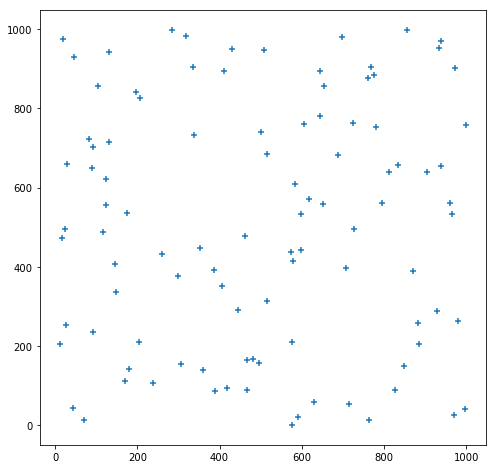

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y, marker="+")
None

In [6]:
# p-values
cells[...,1] * 100

array([[ 39. ,  99.9,   2.8,  99.9],
       [ 56.4,   7.2,  77.7,  58.5],
       [  8.9,  91. ,  42.3,  98.4],
       [ 65.3,  25.7,  39.8,  84.4]])

In [7]:
cells[1,3,1], calculator.space_bins[1], calculator.time_bins[3]

(0.58499999999999996,
 (20, 40),
 (numpy.timedelta64(432000000,'ms'), numpy.timedelta64(864000000,'ms')))

## Distribution

In [8]:
calculator = knox.Knox()
calculator.space_bins = [(0,20), (20,40), (40,80), (80,200)]
calculator.set_time_bins([(0,1), (1,2), (2,5), (5,10)], unit="days")

all_p_values = []
for _ in range(10):
    calculator.data = open_cp.TimedPoints.from_coords(*make_some_data())
    cells = calculator.calculate()
    all_p_values.extend( cells[...,1].flatten() )

(array([ 15.,  10.,  10.,  14.,  14.,  12.,   8.,  19.,  20.,  38.]),
 array([ 0.001 ,  0.1008,  0.2006,  0.3004,  0.4002,  0.5   ,  0.5998,
         0.6996,  0.7994,  0.8992,  0.999 ]),
 <a list of 10 Patch objects>)

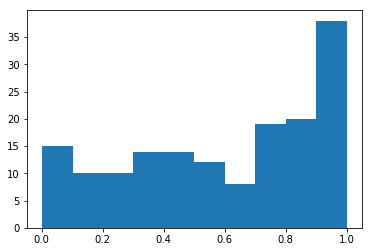

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(all_p_values)